In [2]:
%%capture
import os
import sys
import random
import numpy as np
import pandas as pd
import cv2
from keras.preprocessing.image import img_to_array
try:
    from imutils import paths
except ImportError:
    !pip install imutils
    from imutils import paths
    
import matplotlib.pyplot as plt
%matplotlib inline


In [8]:
# lets start by examining the number of images available in training set
dir_train = "../input/intel-image-classification/seg_train/seg_train/"
for segment in os.listdir(dir_train):
    print("'{}' images in '{}' category".format(
        len(list(paths.list_images(dir_train + segment))),
        segment
    ))
print("Total '{}' images in training set".format(len(list(paths.list_images(dir_train)))))

'2271' images in 'forest' category
'2191' images in 'buildings' category
'2404' images in 'glacier' category
'2382' images in 'street' category
'2512' images in 'mountain' category
'2274' images in 'sea' category
Total '14034' images in training set


So the training set looks failry balanced with similar number of images in each class. Let's pick some random images from each class and try to visualize them

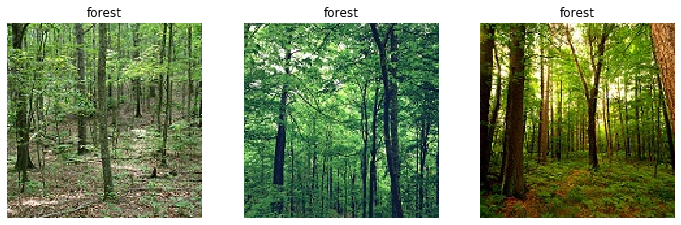

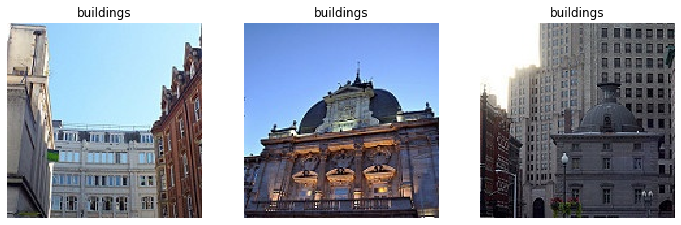

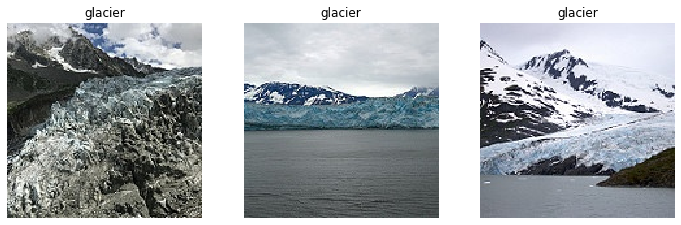

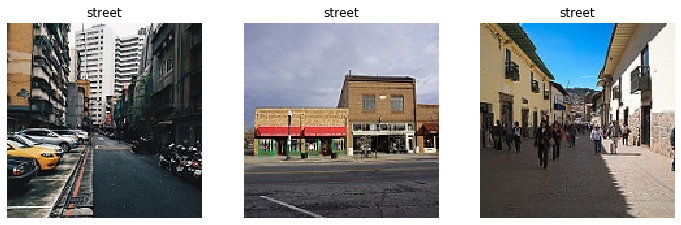

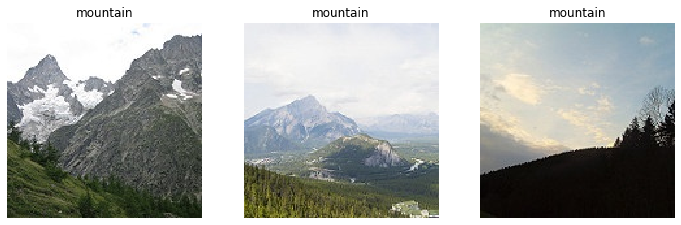

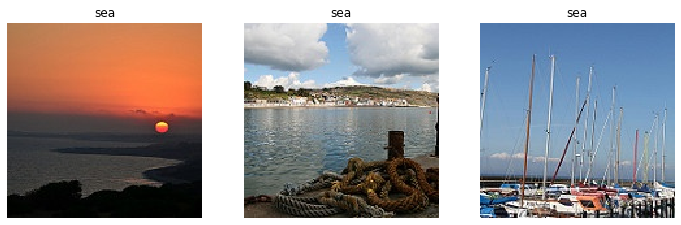

In [19]:
# define classes
columns = 3
classes = {
    "forest":[cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB) 
              for img in random.sample(list(paths.list_images(dir_train + "forest")), columns)], 
    "buildings": [cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB) 
                  for img in random.sample(list(paths.list_images(dir_train + "buildings")), columns)],
    "glacier": [cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB) 
                  for img in random.sample(list(paths.list_images(dir_train + "glacier")), columns)],
    "street": [cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB) 
                  for img in random.sample(list(paths.list_images(dir_train + "street")), columns)],
    "mountain": [cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB) 
                  for img in random.sample(list(paths.list_images(dir_train + "mountain")), columns)],
    "sea": [cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB) 
                  for img in random.sample(list(paths.list_images(dir_train + "sea")), columns)],
}

# this method displays images for 'n' classes above and below
def display(classes, columns, read_as_rgb=True, cmap=None):
    for _class in classes:
        #print(random_images)
        fig, axes = plt.subplots(nrows=1, ncols=columns, figsize=(10, 10), squeeze=False)
        fig.tight_layout()
        for l in range(1):
            for m, img in enumerate(classes[_class]):
                axes[l][m].imshow(img, cmap=cmap)
                axes[l][m].axis("off")
                axes[l][m].set_title(_class)
    # done displaying
    
# display images
display(classes, columns)